In [1]:
import numpy as N
from __future__ import division
import matplotlib.pyplot as plt

In [2]:
"""HPD.py
This code was taken form the PyMC library https://github.com/pymc-devs/pymc
"""

def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """

    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(N.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = N.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_min, hdi_max


def hpd(x, alpha=0.05):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI).
    :Arguments:
        x : Numpy array
        An array containing MCMC samples
        alpha : float
        Desired probability of type I error (defaults to 0.05)
    """

    # Make a copy of trace
    x = x.copy()
    # For multivariate node
    if x.ndim > 1:
        # Transpose first, then sort
        tx = N.transpose(x, list(range(x.ndim))[1:]+[0])
        dims = N.shape(tx)
        # Container list for intervals
        intervals = N.resize(0.0, dims[:-1]+(2,))

        for index in make_indices(dims[:-1]):
            try:
                index = tuple(index)
            except TypeError:
                pass

            # Sort trace
            sx = N.sort(tx[index])
            # Append to list
            intervals[index] = calc_min_interval(sx, alpha)
        # Transpose back before returning
        return N.array(intervals)
    else:
        # Sort univariate node
        sx = N.sort(x)
        return N.array(calc_min_interval(sx, alpha))

In [8]:
def BernGrid(theta , pTheta , data , cred = 0.95, **kwargs):
    """
    Bayesian updating for Bernoulli liklihood and prior specified on a grid.
    
    Input arguments:
        theta: vector, b/w 0 and 1
        pTheta: vecor of corresp. probability masses
        data: vector of 1's and 0's, where 1 corresponds to a and 0 to b.
        cred: prob mass of credible interval, defaults to 0.95
        nToPlot: number of grid points to plot, defaults to all specified in theta
    
    Output:
        pThetaGivenData: vector, posterior probabil. masses over theta.
        3-panel graph of prior, likelihood, and posterior w/ cred. interval.
        
    Example of use:
        Create vector of theta values
            
            binwidth = 1/1000
            thetagrid = N.arange(binwidth/2 1+binwidth/2, binwidth)
            
        Specify probability mass at each theta value
            
            relprob =  -> define relative probability at each theta value
            prior = relprob / sum(relprob) -> prob mass at each theta value
        
        Specify the data vector
            
            datavec = 3 * [1] + 2 * [0]
        
        Call BernGrid: 
            
            posterior = BernGrid(theta = thetagrid,pTheta = prior,data = datavec)
    
    """
    if 'nToPlot' in kwargs.keys():
        nToPlot = kwargs['nToPlot']
    else:
        nToPlot = len(theta)
        
    z = sum(data) # number of heads (1s)
    ndata = len(data)
    
    # compute the likelihood of the data for each value of theta
    pDataGivenTheta = theta ** z * (1 - theta) ** (ndata - z)
    
    # compute the evidence and the posterior
    pData = sum(pDataGivenTheta * pTheta)
    pThetaGivenData = pTheta * pDataGivenTheta / pData
    
    # determine the limits of the highest density interval
    x = N.random.choice(theta,size=5000,replace=True,p=pThetaGivenData)
    intervals = hpd(x,alpha=1-cred)
    
# Plot the results:
    plt.figure(figsize = (16,12))
    plt.subplots_adjust(hspace=0.7)
    
    # Plot the prior
    locx = 0.05
    meanTheta = sum(theta * pTheta) # mean of prior
    plt.subplot(3,1,1)
    plt.plot(theta,pTheta)
    plt.xlim(0,1)
    plt.ylim(0,N.max(pTheta) * 1.2)
    plt.xlabel(r'$\theta$',fontsize=16)
    plt.ylabel(r'$P(\theta)$',fontsize=16)
    plt.title('Prior')
    plt.text(locx,N.max(pTheta)*.75,r'$\theta_{mean}$=%5.2f' % meanTheta,fontsize=16)
    
    #Plot the likelihood
    plt.subplot(3,1,2)
    plt.plot(theta,pDataGivenTheta)
    plt.xlim(0,1)
    plt.ylim(0,N.max(pDataGivenTheta)*1.2)
    plt.xlabel(r'$\theta$',fontsize=16)
    plt.ylabel(r'$P(D|\theta)$',fontsize=16)
    plt.title('Likelihood')
    plt.text(locx,N.max(pDataGivenTheta) / 2,'data: z=%s, N=%s' %(z,ndata),fontsize=16)
    
    #Plot the posterior
    meanThetaGivenData = sum(theta*pThetaGivenData)
    plt.subplot(3,1,3)
    plt.plot(theta,pThetaGivenData)
    plt.xlim(0,1)
    plt.ylim(0,N.max(pThetaGivenData) * 1.2)
    plt.xlabel(r'$\theta$',fontsize=16)
    plt.ylabel(r'$P(\theta|D)$',fontsize=16)
    plt.title('Posterior')
    locy = N.linspace(0,N.max(pThetaGivenData),5)
    plt.text(locx,locy[1],r'$\theta_{mean}$=%5.2f' % meanThetaGivenData,fontsize=16)
    plt.text(locx,locy[2],'P(D) = %g' % pData,fontsize = 16)
    
    #plot HDIs
    plt.text(locx,locy[3],
            'Intervals=%s' % ', '.join('%.3f' % x for x in intervals),fontsize=16)
    for i in range(0,len(intervals),2):
        plt.fill_between(theta,0,pThetaGivenData,
                         where=N.logical_and(theta > intervals[i],
                                             theta < intervals[i+1]),
                        color='blue',alpha=0.3)
    plt.show()
    return pThetaGivenData   

In [9]:
%matplotlib inline

In [10]:
# EX. 6.1
nIntervals = 10
width =1/nIntervals
theta = N.arange(width/2, 1+width/2,width)

In [11]:
theta

array([ 0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,  0.75,  0.85,  0.95])

In [12]:
from scipy.stats import beta
apm = beta.pdf(theta,8,4)*width
pt = apm / sum(apm)

In [64]:
# -A)
sum(apm)

0.99914210794921843

In [66]:
# - B)
# Numbers are mid bins to insure bin size consistency. The below does not support that in that
# the edge bins now contain impossible values, <0 and >1 on either end...
ti = N.arange(0,1+width,width)
ti

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

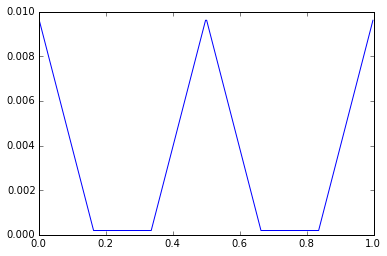

In [13]:
# EX.6.2
maxV = 50
step = 1.0
minV = 1
numSteps=maxV/step +1
pTheta = N.concatenate([N.arange(maxV,-step+minV,-step),N.repeat(minV,numSteps),N.arange(minV,maxV+step,step),
                        N.arange(maxV,-step+minV,-step),N.repeat(minV,numSteps),N.arange(minV,maxV+step,step)])
width = 1.0/len(pTheta)
theta = N.arange(width/2.0,1 + width/2.0 ,width)
pTheta = pTheta/N.sum(pTheta)
plt.plot(theta,pTheta)

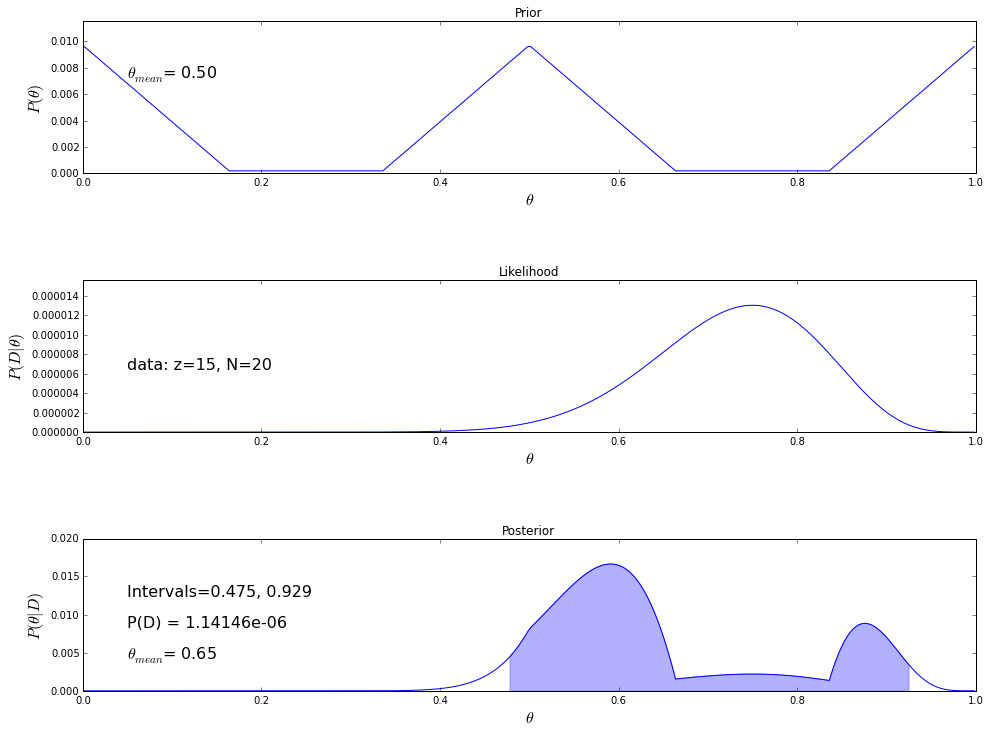

In [14]:
# -B)
datavec=15*[1]+5*[0]
post=BernGrid(theta,pTheta,datavec)

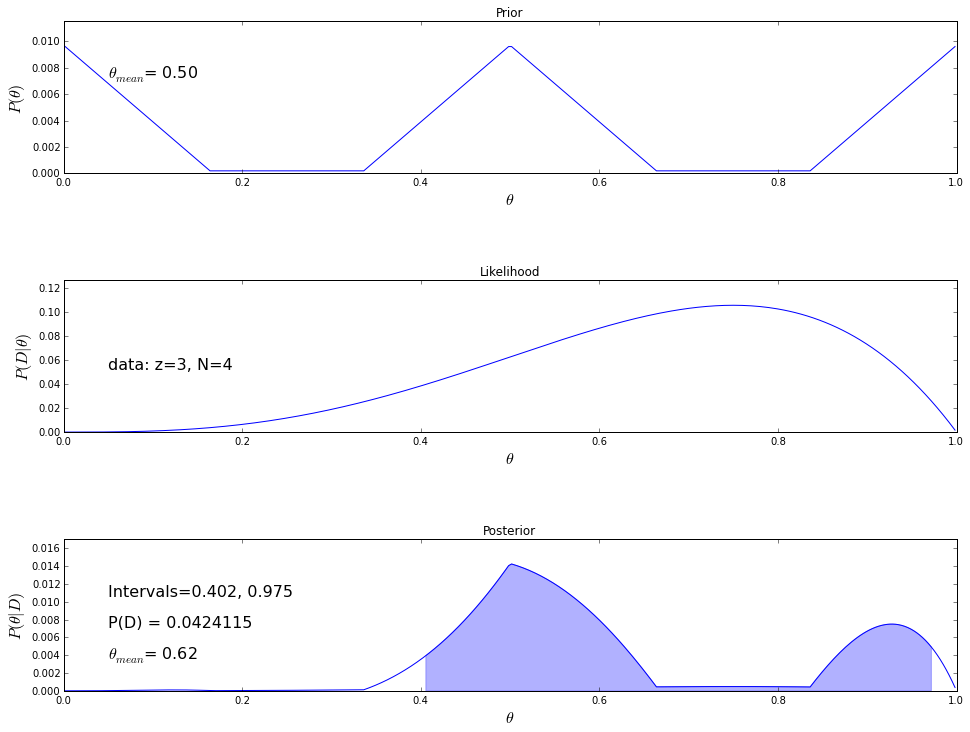

In [15]:
#Ex.6.3
#-A)
datavec=3*[1]+1*[0]
post1=BernGrid(theta,pTheta,datavec)

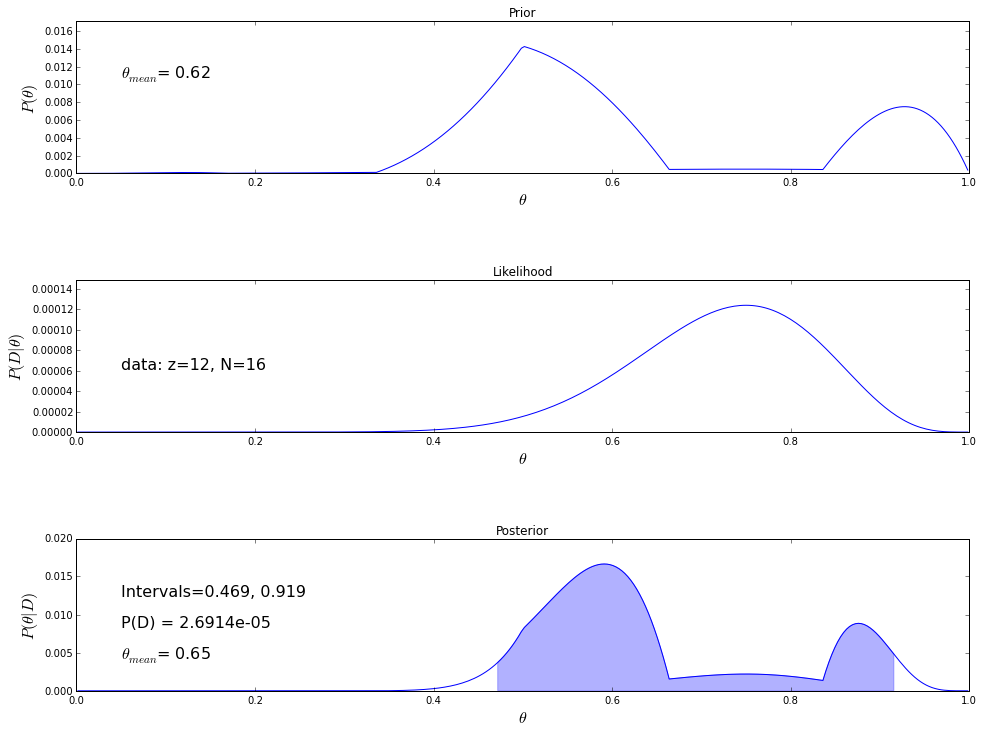

In [16]:
#-B)
datavec=12*[1]+4*[0]
post2=BernGrid(theta,post1,datavec)

In [27]:
#Ex.6.4
dataVec = N.repeat([1,0],[58,42])
#-A)
bins = 100
pTheta = N.ones(bins)
pTheta = pTheta/N.sum(pTheta)

width = 1/len(pTheta)
theta = N.arange(width/2,1+width/2,width)

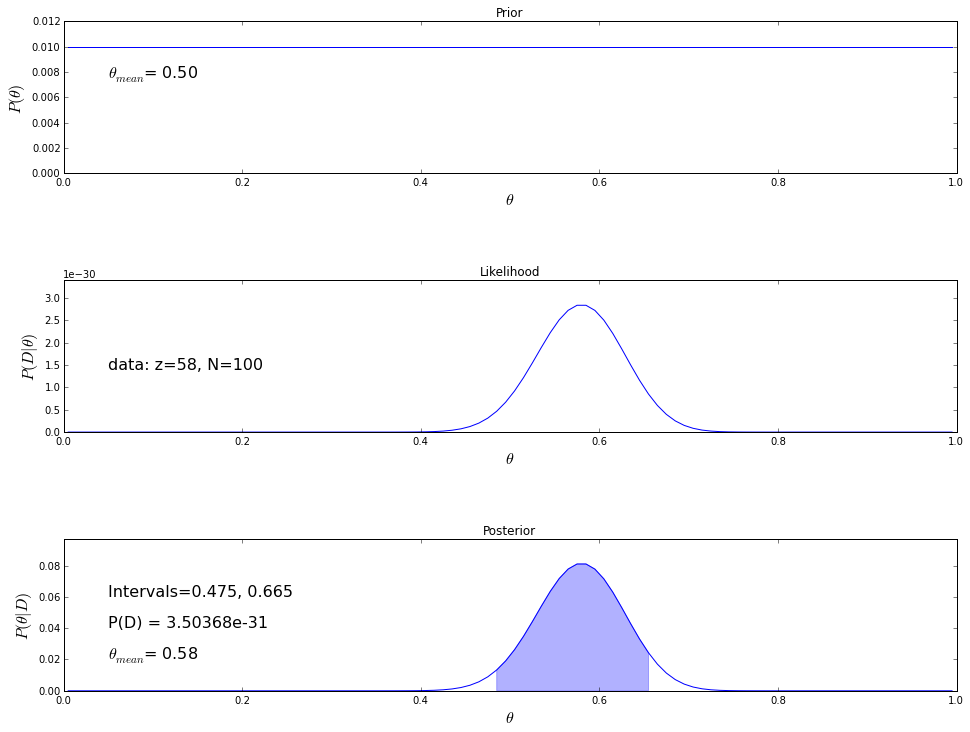

In [31]:
postPoll = BernGrid(theta,pTheta,dataVec)

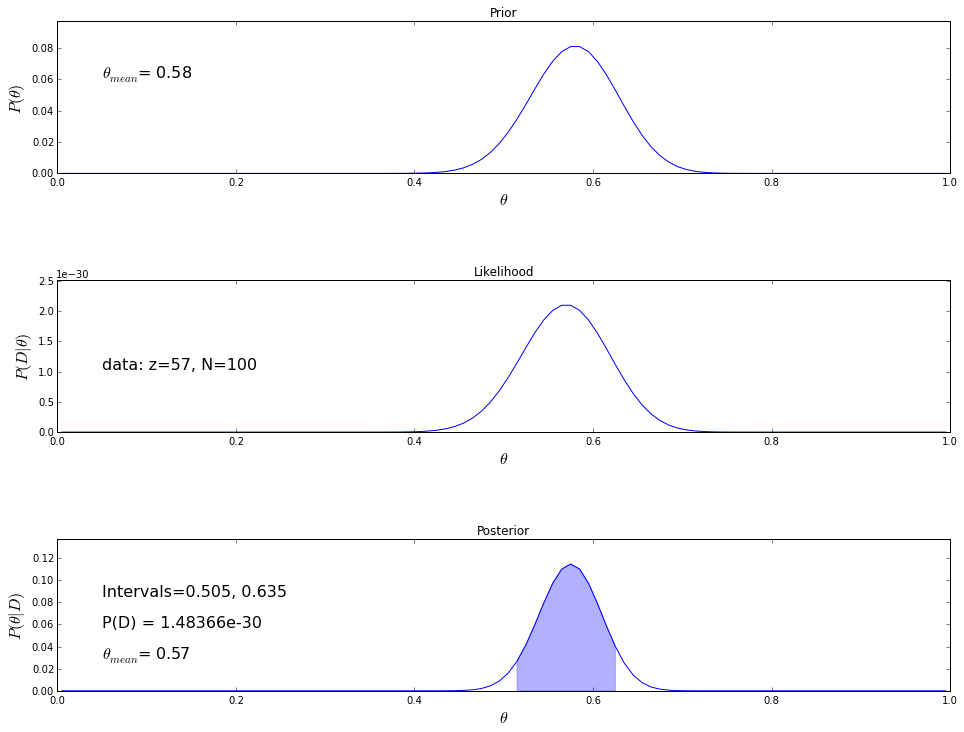

In [33]:
#-B) It is credible to believe that the population is equally divided because 0.5 is within the 95% credible interval
#-C) 
newData = N.repeat([1,0],[57,43])
postPoll2 = BernGrid(theta,postPoll,newData)

In [ ]:
 #-D) With new data, we can no longer say that the population is equally divided: